<a href="https://colab.research.google.com/github/HugoAGFM/spark-logistic-regression-model/blob/main/Logistic_Regression_Model_with_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brazil Highway Traffic Accidents Classification Model Using Spark

## Introduction

This work proposes to create a classification model over a dataset containing Brazil highway traffic accidents data using Apache Spark. The model intends to predict if a person involved in an accident survived or not. This is a continuation of a [data analysis using Apache Spark](https://colab.research.google.com/drive/16KNODsD_wrWP8vZKynHybvHcFI-WvJ-_#scrollTo=j-YYFzW-1Ez3).

## About Dataset

The dataset under analysis is available in [kaggle](https://www.kaggle.com/datasets/mcamera/brazil-highway-traffic-accidents) and contains data from Brazil's federal higways between 2007 and 2021 at various levels of granularity.

The level of granularity chosen was 'accidents per person', and, because there's been  a change in the system used to record these data in 2017, this analysis will be restricted to the period of 2017 to 2021. The files are available [here](https://drive.google.com/drive/u/0/folders/1ue0XT3qt7dknBmV_oykird_6O2Rld723)


### Columns description

Below you can find the columns present in the dataset with a brief description, and how they've been mapped to each table in the data model.

| Coloumn                | Description                                                 | Table             |
| :--------------------- | :---------------------------------------------------------- | :---------------- |
| id                     | ID of accident                                              | Accidents         |
| data_inversa           | Date when accident hapened                                  | Accidents         |
| dia_semana             | Weekday when accident happened                              | Accidents         |
| horario                | Time when accident happened                                 | Accidents         |
| uf                     | Federal Unit where accident happened                        | Accidents         |
| br                     | Highway where accident happened                             | Accidents         |
| km                     | Highway kilometer where accident happened                  | Accidents         |
| municipio              | City where accident happened                                | Accidents         |
| causa_acidente         | Accident cause                                              | Accidents         |
| tipo_acidente          | Accident type                                               | Accidents         |
| classificacao_acidente | Accident classification                                     | Accidents         |
| fase_dia               | Pereiod of the day when  accident happened                  | Accidents         |
| sentido_via            | Lane direction where accident happened                      | Accidents         |
| condicao_metereologica | Weather condition when accident happened                    | Accidents         |
| tipo_pista             | Lane type where accident happened                           | Accidents         |
| tracado_via            | Lane layout where accident happened                         | Accidents         |
| uso_solo               | If the vehicle left the lane in the accident                                   | Accidents         |
| id_veiculo             | ID of vehicle involved in the accident                      | Accidents/Vehicle |
| tipo_veiculo           | Type of the vehicle involved in the accident                | Vehicle           |
| marca                  | Brand of the vehicle involved in the accident               | Vehicle           |
| ano_fabricacao_veiculo | Year of manufacture of the vehicle involved in the accident | Vehicle           |
| pesid                  | ID of person involved in the accident                       | Accidents/People  |
| tipo_envolvido         | Type of person involved in the accident                     | People            |
| estado_fisico          | Physical state of the person involved in the accident       | People            |
| idade                  | Age of the person involved in the accident                  | People            |
| sexo                   | Sex of the person involved in the accident                  | People            |

### Data model

For the purpose of this work and following the instructions of the professor, the dataset was denormalized and modeled as three different tables as described below.

| Table     | Description                                                                                                             |
| :-------- | :---------------------------------------------------------------------------------------------------------------------- |
| Accidents | Accidents records. Relates to table People through column 'pesid', and with table Vehicles through column 'id_veiculo'. |
| People    | Information about the people involved in the accidents. Relates to the table Accidents through column 'pesid'.           |
| Vehicles  | Information about the veicles involved in the accidents. Relates to the table Accidents thorugh column 'id_veiculo'.                                                |


## Preparing Environment

This session contains all the steps taken to prepare the analytical environment.

### Install pyspark

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=dae8c4c08864dd8b688943b60cbeef5368090ba25102246a7e3f6729065b0878
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


### Mount Google Drive into Google Colab machine

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import and instanciate Spark Session

Spark Session consists of the entrypoint for the Spark SQL API. This work will run in a local environment.

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .getOrCreate()

## Exploring Dataset
This section intends to explore the datasets' attributes to better clean it and select the appropriate features.

In [ ]:
df_people = spark.read \
  .options(delimiter=";") \
  .csv("/content/drive/MyDrive/traffic/people.csv",
       inferSchema=True,
       header=True,
       encoding="Latin1")

df_accidents = spark.read \
  .options(delimiter=";") \
  .csv("/content/drive/MyDrive/traffic/accidents.csv",
       inferSchema=True,
       header=True,
       encoding="Latin1")

df_vehicles = spark.read \
  .options(delimiter=";") \
  .csv("/content/drive/MyDrive/traffic/vehicles.csv",
       inferSchema=True,
       header=True,
       encoding="Latin1")

### Evaluating people dataframe

- "tipo_envolvido" equal to "Testemunha" is going to be excluded from the dataset, becuase these people are not actually involved in the accident;
- "tipo_envolvido" equal to "Não Informado" is going to be excluded from the dataset, because it represents lack of information;
- "tipo_envolvido" equal to "Cavaleiro" is going to be excluded from the dataset, because of the low number of occurences;
- "estado_fisico" equal to "Não Infromado" is going to be excluded from the dataset, because it represents lack of information.

In [ ]:
df_people.printSchema()

root
 |-- pesid: integer (nullable = true)
 |-- tipo_envolvido: string (nullable = true)
 |-- estado_fisico: string (nullable = true)
 |-- idade: double (nullable = true)
 |-- sexo: string (nullable = true)



In [ ]:
df_people.groupBy("tipo_envolvido").count().show()

+--------------+------+
|tipo_envolvido| count|
+--------------+------+
| Não Informado|     1|
|    Passageiro|192952|
|    Testemunha| 15057|
|      Pedestre| 16005|
|      Condutor|525851|
|     Cavaleiro|   178|
+--------------+------+



In [ ]:
df_people.groupby("estado_fisico").count().show()

+-------------+------+
|estado_fisico| count|
+-------------+------+
|        Ileso|336312|
|Não Informado| 43577|
| Lesões Leves|265215|
|        Óbito| 24610|
|Lesões Graves| 80330|
+-------------+------+



### Evaluating vehicles dataframe


- "tipo_veiculo" with less than 1000 occurences will be excluded from the dataset to streamline the model.

In [ ]:
df_vehicles.printSchema()

root
 |-- id_veiculo: integer (nullable = true)
 |-- tipo_veiculo: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- ano_fabricacao_veiculo: integer (nullable = true)



In [ ]:
df_vehicles.groupBy("tipo_veiculo").count().orderBy("count", ascending=False).show(50)

+-----------------+------+
|     tipo_veiculo| count|
+-----------------+------+
|        Automóvel|216775|
|      Motocicleta|107285|
|  Caminhão-trator| 55106|
|      Caminhonete| 46863|
|         Caminhão| 44957|
|         Motoneta| 12580|
|        Camioneta| 12222|
|        Bicicleta|  8787|
|           Ônibus|  8081|
|       Utilitário|  5420|
|     Micro-ônibus|  2509|
|           Outros|  2069|
|       Ciclomotor|  1661|
|      Semireboque|  1057|
|  Trator de rodas|   289|
| Carroça-charrete|   258|
|          Reboque|   180|
|         Triciclo|    63|
|    Não Informado|    53|
|       Trem-bonde|    28|
|     Carro de mão|    26|
|     Trator misto|    14|
|Trator de esteira|    11|
|Chassi-plataforma|     9|
|      Quadriciclo|     9|
+-----------------+------+



### Evaluating accidents dataframe

In [ ]:
df_accidents.printSchema()

root
 |-- id: integer (nullable = true)
 |-- data_inversa: date (nullable = true)
 |-- dia_semana: string (nullable = true)
 |-- horario: timestamp (nullable = true)
 |-- uf: string (nullable = true)
 |-- br: integer (nullable = true)
 |-- km: double (nullable = true)
 |-- municipio: string (nullable = true)
 |-- causa_acidente: string (nullable = true)
 |-- tipo_acidente: string (nullable = true)
 |-- classificacao_acidente: string (nullable = true)
 |-- fase_dia: string (nullable = true)
 |-- sentido_via: string (nullable = true)
 |-- condicao_metereologica: string (nullable = true)
 |-- tipo_pista: string (nullable = true)
 |-- tracado_via: string (nullable = true)
 |-- uso_solo: string (nullable = true)
 |-- pesid: integer (nullable = true)
 |-- id_veiculo: integer (nullable = true)



In [ ]:
df_accidents.groupBy("tipo_acidente").count().orderBy("count", ascending=False).show(truncate=False)

+-------------------------------+------+
|tipo_acidente                  |count |
+-------------------------------+------+
|Colisão traseira               |170455|
|Colisão transversal            |105800|
|Colisão lateral                |95430 |
|Saída de leito carroçável      |95371 |
|Colisão frontal                |69618 |
|Colisão com objeto estático    |36829 |
|Tombamento                     |36226 |
|Atropelamento de Pedestre      |34997 |
|Capotamento                    |25453 |
|Engavetamento                  |21940 |
|Queda de ocupante de veículo   |20305 |
|Atropelamento de Animal        |10850 |
|Incêndio                       |6531  |
|Colisão lateral mesmo sentido  |6290  |
|Colisão com objeto             |4112  |
|Colisão com objeto em movimento|3892  |
|Colisão lateral sentido oposto |2177  |
|Danos eventuais                |1816  |
|Derramamento de carga          |1705  |
|Eventos atípicos               |251   |
+-------------------------------+------+



In [ ]:
df_accidents.groupBy("uf").count().orderBy("count", ascending=False).show(27)

+---+------+
| uf| count|
+---+------+
| MG|100693|
| SC| 87199|
| PR| 84137|
| RS| 52429|
| RJ| 49858|
| SP| 47779|
| BA| 41653|
| GO| 37623|
| PE| 29409|
| ES| 28207|
| MT| 25853|
| CE| 17964|
| RO| 17830|
| MS| 17200|
| PB| 16383|
| RN| 14380|
| PI| 14081|
| MA| 14081|
| PA| 12424|
| DF| 11239|
| AL|  7228|
| TO|  6718|
| SE|  6432|
| AC|  2964|
| RR|  2913|
| AP|  1925|
| AM|  1446|
+---+------+



In [ ]:
df_accidents.groupBy("fase_dia").count().show()

+-----------+------+
|   fase_dia| count|
+-----------+------+
|  Pleno dia|417930|
|Plena Noite|253485|
|  Anoitecer| 43797|
|  Amanhecer| 34836|
+-----------+------+



## Preparing dataset

This section intends to prepare the dataset to feed the Logistic Regression model.

### Cleaning Datset

The columns selected to be features are following the conclusions from the [data analysis](https://colab.research.google.com/drive/16KNODsD_wrWP8vZKynHybvHcFI-WvJ-_#scrollTo=nvuNrBmC6WK9), under the "Extended Data Analysis" section, combined with different attemps of running the model until reaching the best indicators.

Beyond that, the filters applied are following the assumptions from this work's "Exploring Dataset" section.

In [ ]:
from pyspark.sql.functions import when, col

In [ ]:
df_accidents.count()

750048

In [ ]:
df = df_accidents.join(df_people, df_accidents.pesid == df_people.pesid, "left") \
                 .join(df_vehicles, df_accidents.id_veiculo == df_vehicles.id_veiculo, "left") \
                 .where("tipo_envolvido not in ('Não Informado', 'Testemunha', 'Cavaleiro')") \
                 .where("estado_fisico != 'Não Informado'") \
                 .where("tipo_veiculo not in ('Trator de rodas', 'Carroça-charrete', 'Reboque', 'Triciclo', 'Não Informado', 'Trem-bonde', 'Carro de mão', 'Trator misto', 'Trator de esteira', 'Chassi-plataforma', 'Quadriciclo')") \
                 .withColumn("survived", when(col("estado_fisico") == "Óbito", "No").otherwise("Yes")) \
                 .select("survived",
                         "tipo_envolvido",
                         "tipo_veiculo",
                         "tipo_acidente",
                        #  "uf",
                        #  "condicao_metereologica",
                         "fase_dia")

df.show(truncate=False)

+--------+--------------+------------+----------------------------+-----------+
|survived|tipo_envolvido|tipo_veiculo|tipo_acidente               |fase_dia   |
+--------+--------------+------------+----------------------------+-----------+
|Yes     |Condutor      |Motocicleta |Queda de ocupante de veículo|Plena Noite|
|Yes     |Passageiro    |Automóvel   |Capotamento                 |Plena Noite|
|Yes     |Condutor      |Automóvel   |Capotamento                 |Plena Noite|
|Yes     |Condutor      |Automóvel   |Saída de leito carroçável   |Plena Noite|
|Yes     |Condutor      |Automóvel   |Colisão traseira            |Plena Noite|
|Yes     |Passageiro    |Automóvel   |Colisão traseira            |Plena Noite|
|Yes     |Condutor      |Motocicleta |Atropelamento de Animal     |Plena Noite|
|Yes     |Passageiro    |Motocicleta |Atropelamento de Animal     |Plena Noite|
|Yes     |Passageiro    |Automóvel   |Colisão traseira            |Plena Noite|
|Yes     |Passageiro    |Automóvel   |Co

In [ ]:
df.count()

705289

### Creating Label and Features Columns

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer

In [ ]:
label_index = StringIndexer(inputCol="survived", outputCol="label")
involved_type_index = StringIndexer(inputCol="tipo_envolvido", outputCol="indexedInvolvedType")
vehicle_type_index = StringIndexer(inputCol="tipo_veiculo", outputCol="indexedVehicleType")
accident_type_index = StringIndexer(inputCol="tipo_acidente", outputCol="indexedAccidentType")
# federal_unit_index = StringIndexer(inputCol="uf", outputCol="indexedFederalUnit")
# climate_condition_index = StringIndexer(inputCol="condicao_metereologica", outputCol="indexedClimateCondition")
day_phase_index = StringIndexer(inputCol="fase_dia", outputCol="indexedDayPhase")

In [ ]:
encoder = OneHotEncoder(inputCols=["indexedInvolvedType",
                                   "indexedVehicleType",
                                   "indexedAccidentType",
                                  #  "indexedFederalUnit",
                                  #  "indexedClimateCondition",
                                   "indexedDayPhase"],
                        outputCols=["vec_InvolvedType",
                                    "vec_VehicleType",
                                    "vec_AccidentType",
                                    # "vec_FederalUnit",
                                    # "vec_ClimateCondition",
                                    "vec_DayPhase"],
                        dropLast=False)

In [ ]:
assembler = VectorAssembler(inputCols=["vec_InvolvedType",
                                       "vec_VehicleType",
                                       "vec_AccidentType",
                                      #  "vec_FederalUnit",
                                      #  "vec_ClimateCondition",
                                       "vec_DayPhase"],
                            outputCol="features")

In [ ]:
pipeline = Pipeline(stages=[label_index,
                            involved_type_index,
                            vehicle_type_index,
                            accident_type_index,
                            # federal_unit_index,
                            # climate_condition_index,
                            day_phase_index,
                            encoder,
                            assembler])

In [ ]:
prepared_df = pipeline.fit(df).transform(df)

In [ ]:
prepared_df.select("survived", "label",
                   "tipo_envolvido", "indexedInvolvedType", "vec_InvolvedType",
                   "tipo_veiculo", "indexedVehicleType", "vec_VehicleType",
                   "tipo_acidente", "indexedAccidentType", "vec_AccidentType",
                  #  "uf", "indexedFederalUnit", "vec_FederalUnit",
                  #  "condicao_metereologica", "indexedClimateCondition", "vec_ClimateCondition",
                   "fase_dia", "indexedDayPhase", "vec_DayPhase") \
           .show()

+--------+-----+--------------+-------------------+----------------+------------+------------------+---------------+--------------------+-------------------+----------------+-----------+---------------+-------------+
|survived|label|tipo_envolvido|indexedInvolvedType|vec_InvolvedType|tipo_veiculo|indexedVehicleType|vec_VehicleType|       tipo_acidente|indexedAccidentType|vec_AccidentType|   fase_dia|indexedDayPhase| vec_DayPhase|
+--------+-----+--------------+-------------------+----------------+------------+------------------+---------------+--------------------+-------------------+----------------+-----------+---------------+-------------+
|     Yes|  0.0|      Condutor|                0.0|   (3,[0],[1.0])| Motocicleta|               1.0| (14,[1],[1.0])|Queda de ocupante...|               10.0| (20,[10],[1.0])|Plena Noite|            1.0|(4,[1],[1.0])|
|     Yes|  0.0|    Passageiro|                1.0|   (3,[1],[1.0])|   Automóvel|               0.0| (14,[0],[1.0])|         Capotam

In [ ]:
training_df, test_df = prepared_df.randomSplit([0.7, 0.3])

print(f"Number of records in traingn dataset: {training_df.count()}")
print(f"Number of records in test dataset: {test_df.count()}")

Number of records in traingn dataset: 493122
Number of records in test dataset: 212167


## Training and Testing Models

This section intends to use the prepared datasets to train and test a Logistic Regression model capable of predicting if a person involved in an accident survived or not. The indicators of the model and results obtained will be evaluated to understand the quality and how the model can be applied.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [334]:
lr = LogisticRegression()
evaluator = BinaryClassificationEvaluator()

In [ ]:
model = lr.fit(training_df)

In [ ]:
summary = model.summary

print("Accuracy: %s" % str(summary.accuracy))
print("True positive: %s" % str(summary.truePositiveRateByLabel))
print("False positive: %s" % str(summary.falsePositiveRateByLabel))
print(summary.precisionByLabel)
print(summary.recallByLabel)

Accuracy: 0.965375708242585
True positive: [0.9994390744518371, 0.018454710039128658]
False positive: [0.9815452899608713, 0.0005609255481629163]
[0.9658768138157587, 0.5420240137221269]
[0.9994390744518371, 0.018454710039128658]


In [ ]:
roc = summary.roc.toPandas()

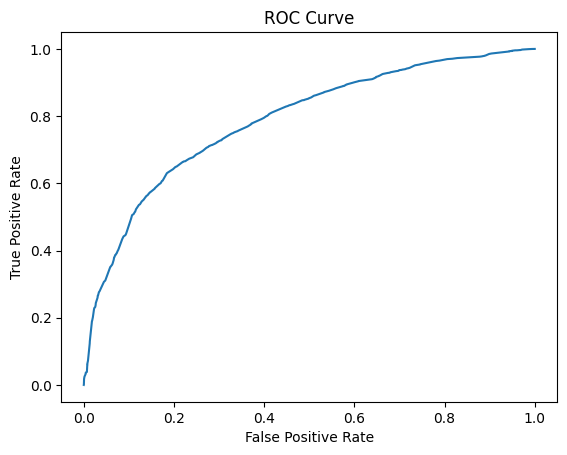

In [ ]:
plt.plot(roc['FPR'],roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
result_df = model.transform(test_df)

In [ ]:
result_df.show()

+--------+--------------+------------+--------------------+-----------+-----+-------------------+------------------+-------------------+---------------+----------------+---------------+----------------+-------------+--------------------+--------------------+--------------------+----------+
|survived|tipo_envolvido|tipo_veiculo|       tipo_acidente|   fase_dia|label|indexedInvolvedType|indexedVehicleType|indexedAccidentType|indexedDayPhase|vec_InvolvedType|vec_VehicleType|vec_AccidentType| vec_DayPhase|            features|       rawPrediction|         probability|prediction|
+--------+--------------+------------+--------------------+-----------+-----+-------------------+------------------+-------------------+---------------+----------------+---------------+----------------+-------------+--------------------+--------------------+--------------------+----------+
|      No|      Condutor|   Automóvel|Atropelamento de ...|Plena Noite|  1.0|                0.0|               0.0|           

In [ ]:
y_true = result_df.select(['label']).collect()
y_pred = result_df.select(['prediction']).collect()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98    204755
         1.0       0.54      0.02      0.04      7412

    accuracy                           0.97    212167
   macro avg       0.75      0.51      0.51    212167
weighted avg       0.95      0.97      0.95    212167



In [ ]:
print(confusion_matrix(y_true, y_pred))

[[204633    122]
 [  7267    145]]


In [ ]:
roc = evaluator.evaluate(result_df)
print(roc)

0.7931020044317897


#### Model and Result evaluation

The model that presented the best results is the one with type of people, type of vehicle, type of accident, and day phase as features.

Although it present a high accuracy, is possible to notice that the precision, recall and f1-socre are only high for cases where the person survived. It happens because most of the cases in the training dataset are of people that survived.

Precisely, the indicator with the lowest score is the recall for people who die. Therefore, the model wouldn't be a good fit if this measurement was the objective.

The next sections will be dedicated to evaluate how different techniques can be applied to try to mitigate the effects of this inbalance and understand how it affects the model and results.

### Oversampling

This approach aims to solve the imbalance by oversampling the cases with fewer occurences in the trainign dataset, by the difference ratio between the possible values of the label. In the current scenario, random copies of cases where people died will be created.

In [330]:
from pyspark.sql.functions import col, explode, array, lit

In [331]:
minor_df = training_df.filter(col("label") == 1)
major_df = training_df.filter(col("label") == 0)

ratio = int(major_df.count() / minor_df.count())

print(f"ratio: {ratio}")

ratio: 27


In [332]:
oversampled_minor_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(ratio)]))).drop("dummy")

oversampled_training_df = major_df.unionAll(oversampled_minor_df)
oversampled_training_df.show()

+--------+--------------+------------+--------------------+---------+-----+-------------------+------------------+-------------------+---------------+----------------+---------------+----------------+-------------+--------------------+
|survived|tipo_envolvido|tipo_veiculo|       tipo_acidente| fase_dia|label|indexedInvolvedType|indexedVehicleType|indexedAccidentType|indexedDayPhase|vec_InvolvedType|vec_VehicleType|vec_AccidentType| vec_DayPhase|            features|
+--------+--------------+------------+--------------------+---------+-----+-------------------+------------------+-------------------+---------------+----------------+---------------+----------------+-------------+--------------------+
|     Yes|      Condutor|   Automóvel|Atropelamento de ...|Amanhecer|  0.0|                0.0|               0.0|               11.0|            3.0|   (3,[0],[1.0])| (14,[0],[1.0])| (20,[11],[1.0])|(4,[3],[1.0])|(41,[0,3,28,40],[...|
|     Yes|      Condutor|   Automóvel|Atropelamento de .

In [335]:
oversampled_model = lr.fit(oversampled_training_df)

In [336]:
oversampled_summary = oversampled_model.summary

print("Accuracy: %s" % str(oversampled_summary.accuracy))
print("True positive: %s" % str(oversampled_summary.truePositiveRateByLabel))
print("False positive: %s" % str(oversampled_summary.falsePositiveRateByLabel))
print(oversampled_summary.precisionByLabel)
print(oversampled_summary.recallByLabel)

Accuracy: 0.721205378096758
True positive: [0.7851303519018488, 0.6551703946597962]
False positive: [0.3448296053402038, 0.21486964809815126]
[0.701672292258073, 0.746945859943479]
[0.7851303519018488, 0.6551703946597962]


In [337]:
oversampled_roc = oversampled_summary.roc.toPandas()

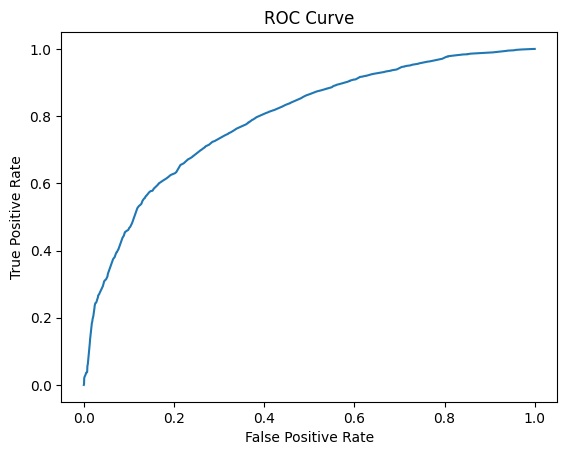

In [338]:
plt.plot(oversampled_roc['FPR'],oversampled_roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [339]:
oversampled_result_df = oversampled_model.transform(test_df)

In [340]:
y_true = oversampled_result_df.select(['label']).collect()
y_pred = oversampled_result_df.select(['prediction']).collect()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.79      0.87    204755
         1.0       0.10      0.66      0.17      7412

    accuracy                           0.78    212167
   macro avg       0.54      0.72      0.52    212167
weighted avg       0.95      0.78      0.85    212167



In [341]:
print(confusion_matrix(y_true, y_pred))

[[160784  43971]
 [  2547   4865]]


In [342]:
oversampled_roc = evaluator.evaluate(oversampled_result_df)
print(oversampled_roc)

0.7955430899917336


### Undersampling

This approach aims to solve the imbalance by undersampling the cases with more occurences in the trainign dataset, by the difference ratio between the possible values of the label. In the current scenario, a random sample of cases where people survived will be extracted.

In [343]:
undersampled_major_df = major_df.sample(False, 1/ratio)
undersampled_training_df = undersampled_major_df.unionAll(minor_df)

undersampled_training_df.show()

+--------+--------------+------------+--------------------+-----------+-----+-------------------+------------------+-------------------+---------------+----------------+---------------+----------------+-------------+--------------------+
|survived|tipo_envolvido|tipo_veiculo|       tipo_acidente|   fase_dia|label|indexedInvolvedType|indexedVehicleType|indexedAccidentType|indexedDayPhase|vec_InvolvedType|vec_VehicleType|vec_AccidentType| vec_DayPhase|            features|
+--------+--------------+------------+--------------------+-----------+-----+-------------------+------------------+-------------------+---------------+----------------+---------------+----------------+-------------+--------------------+
|     Yes|      Condutor|   Automóvel|Atropelamento de ...|  Amanhecer|  0.0|                0.0|               0.0|               11.0|            3.0|   (3,[0],[1.0])| (14,[0],[1.0])| (20,[11],[1.0])|(4,[3],[1.0])|(41,[0,3,28,40],[...|
|     Yes|      Condutor|   Automóvel|Atropelame

In [344]:
undersampled_model = lr.fit(undersampled_training_df)

In [345]:
undersampled_summary = undersampled_model.summary

print("Accuracy: %s" % str(undersampled_summary.accuracy))
print("True positive: %s" % str(undersampled_summary.truePositiveRateByLabel))
print("False positive: %s" % str(undersampled_summary.falsePositiveRateByLabel))
print(undersampled_summary.precisionByLabel)
print(undersampled_summary.recallByLabel)

Accuracy: 0.7240307400051809
True positive: [0.7892442683272006, 0.6565757114416207]
False positive: [0.3434242885583792, 0.21075573167279932]
[0.7038925632352199, 0.7507364756293519]
[0.7892442683272006, 0.6565757114416207]


In [346]:
undersampled_roc = undersampled_summary.roc.toPandas()

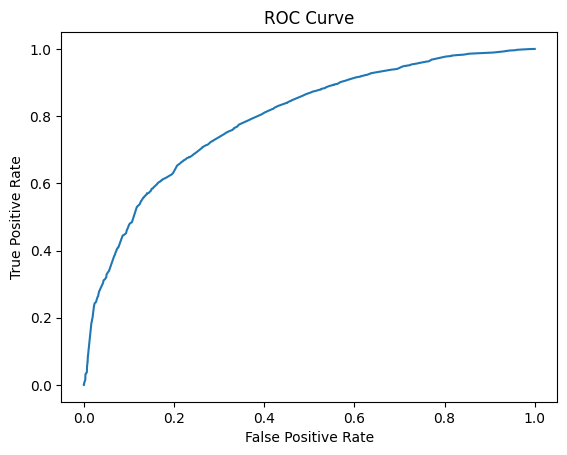

In [347]:
plt.plot(undersampled_roc['FPR'],undersampled_roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [348]:
undersampled_result_df = undersampled_model.transform(test_df)

In [349]:
y_true = undersampled_result_df.select(['label']).collect()
y_pred = undersampled_result_df.select(['prediction']).collect()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87    204755
         1.0       0.10      0.66      0.17      7412

    accuracy                           0.78    212167
   macro avg       0.54      0.72      0.52    212167
weighted avg       0.95      0.78      0.85    212167



In [350]:
print(confusion_matrix(y_true, y_pred))

[[160519  44236]
 [  2539   4873]]


In [351]:
undersampled_roc = evaluator.evaluate(undersampled_result_df)
print(undersampled_roc)

0.7955154286967651


### Weighting

This approach aims to solve the imbalance by assigning weights to the labels based on the frequency of their occurencies. The label with higher frequency receives a lower weight and the one with lower frequency a higher weight.


In [352]:
ratio = minor_df.count() / training_df.count()

ratio

0.034723658648366934

In [353]:
weighted_df = training_df.withColumn("weight", when(col("label") == 1, 1 - ratio).otherwise(ratio))

weighted_df.select("label", "features", "weight").show()

+-----+--------------------+------------------+
|label|            features|            weight|
+-----+--------------------+------------------+
|  1.0|(41,[0,3,28,40],[...|0.9652763413516331|
|  1.0|(41,[0,3,28,40],[...|0.9652763413516331|
|  1.0|(41,[0,3,28,40],[...|0.9652763413516331|
|  1.0|(41,[0,3,28,38],[...|0.9652763413516331|
|  1.0|(41,[0,3,28,38],[...|0.9652763413516331|
|  1.0|(41,[0,3,28,38],[...|0.9652763413516331|
|  1.0|(41,[0,3,28,38],[...|0.9652763413516331|
|  1.0|(41,[0,3,28,38],[...|0.9652763413516331|
|  1.0|(41,[0,3,24,40],[...|0.9652763413516331|
|  1.0|(41,[0,3,24,38],[...|0.9652763413516331|
|  1.0|(41,[0,3,24,38],[...|0.9652763413516331|
|  1.0|(41,[0,3,24,38],[...|0.9652763413516331|
|  1.0|(41,[0,3,24,38],[...|0.9652763413516331|
|  1.0|(41,[0,3,24,38],[...|0.9652763413516331|
|  1.0|(41,[0,3,24,37],[...|0.9652763413516331|
|  1.0|(41,[0,3,24,37],[...|0.9652763413516331|
|  1.0|(41,[0,3,24,37],[...|0.9652763413516331|
|  1.0|(41,[0,3,25,40],[...|0.9652763413

In [354]:
weighted_model = lr.setWeightCol("weight").fit(weighted_df)

In [355]:
weighted_summary = weighted_model.summary

print("Accuracy: %s" % str(weighted_summary.accuracy))
print("True positive: %s" % str(weighted_summary.truePositiveRateByLabel))
print("False positive: %s" % str(weighted_summary.falsePositiveRateByLabel))
print(weighted_summary.precisionByLabel)
print(weighted_summary.recallByLabel)

Accuracy: 0.719141197237061
True positive: [0.780512143933787, 0.6577702505401918]
False positive: [0.34222974945980816, 0.2194878560662131]
[0.6951839496922757, 0.7498024191356095]
[0.780512143933787, 0.6577702505401918]


In [356]:
weighted_roc = weighted_summary.roc.toPandas()

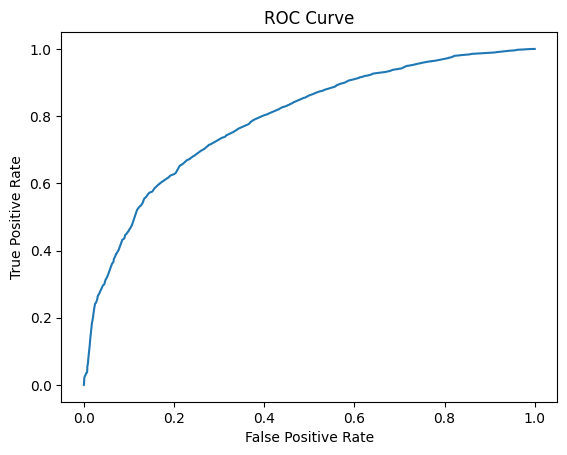

In [357]:
plt.plot(weighted_roc['FPR'],weighted_roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [358]:
weighted_result_df = weighted_model.transform(test_df)

In [359]:
y_true = weighted_result_df.select(['label']).collect()
y_pred = weighted_result_df.select(['prediction']).collect()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87    204755
         1.0       0.10      0.66      0.17      7412

    accuracy                           0.78    212167
   macro avg       0.54      0.72      0.52    212167
weighted avg       0.95      0.78      0.85    212167



In [360]:
print(confusion_matrix(y_true, y_pred))

[[159714  45041]
 [  2510   4902]]


In [361]:
weighted_roc = evaluator.evaluate(weighted_result_df)
print(weighted_roc)

0.7952170998514625


### Inbalance treatment techniques evaluation

All different techniques presented similar results. When compared to the original model, they've presented an increase of the recall and f1-score for death cases, in exchange of a decrese in the accuracy, precision for death cases, and recall and f1-score for survival cases.

For scenarios where a good recall indicator for death cases is necessary, these models would be a better fit than the original one.

## Future Work

For future work, there are two options to highlight:
1. Test different attributes of the dataset and how they affect the model and results.
2. Try to implement feature seelction algorithms to understand how they affect the model and results.